In [157]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import expon
from scipy.optimize import minimize_scalar
import cvxpy as cp
import heapq


# Data, E, S, M

In [158]:
def dataEntryCreator(d, A=0, B=0, mean=0, variance=0, lbd=0):
    '''
    This funtion will return a dataset with specific columns and rows(m, d) 
    in one specific distribution depend on parameters.
    
    Argument:
    d - Amount of values in each data entry
    A, B - parameters of uniform distribution
    mean, variance - parameters of normal distribution
    lbd - lambda is the parameter of exponential distribution
    
    Return:
    de - Data entry created with one specific distribution
    '''
    de = np.zeros(d)
    
    #uniform distribution
    if A!=0 and B!=0: 
        if mean!=0 or variance!=0 or lbd!=0:#checker of proper input
            return de
        de = np.random.uniform(A, B, d)
    
    #normal distribution
    elif mean!=0 or variance!=0:
        if A!=0 or B!=0 or lbd!=0: #checker of proper input
            return de
        de = np.random.normal(mean, variance, d)
    
    #exponential distribution
    elif lbd!=0:
        if A!=0 or B!=0 or mean!=0 or variance!=0: #checker of proper input
            return de
        de = np.random.exponential(lbd, d)
        
    return de

In [159]:
# MONTE CARLO SIMULATION

# Function for testing if X1 is among the top k
def isFirstEntryAmongTopK_mce(de, k):
#     top_k_elements = heapq.nlargest(k, de)
#     if de[0] in top_k_elements:
#         return de[0], 1
#     else:
#         return 0, 0
    kth_largest = np.partition(de, -k)[-k]  # Partially sort and get the kth largest
    if de[0] >= kth_largest:
        return de[0], 1
    else:
        return 0, 0    

# Function for estimating the conditional expectation
def expectation_of_xAndx2(dt, k):
    t = 0
    t2 = 0
    num = 0
    for de in dt:
        res = isFirstEntryAmongTopK_mce(de, k)
        t += res[0]
        t2 += res[0]**2
        num += res[1]
    if num == 0:
        num = 1
    return t/num, t2/num

# Function for estimating the conditional expectation of the squared variable
# def expected_xi_2(dt, k):
#     t2 = 0
#     dt2 = [de**2 for de in dt]
#     num = 0
#     for i in range(len(dt)):
#         res = isFirstEntryAmongTopK_mce(dt[i], k)
#         if res[0] != 0:
#             t2 += dt2[i][0]
#             num += res[1]
#     if num == 0:
#         num = 1
#     return t2/num

In [160]:
# Function for E(Q^TQ)
def eQTQ_ks(k, E, S, d):
    m = len(E)
    eQTQ = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            if i != j:
                eQTQ[i][j] = k[i] * k[j] * E[i] * E[j] / d
            else:
                eQTQ[i][j] = S[i] * k[i]

    return eQTQ

# Function for E(z^TQ)
def eZTQ_ks(k, E, M, S, d):
    m = len(E)
    eZTQ = np.zeros(m)
    for i in range(m):
        eZTQ[i] = (k[i] * (S[i] + E[i] * M.sum() - E[i]*M[i]))/d
    return eZTQ

# Function for the equality constraint matrix A and vector b
def equal_constr_ks(k, E, M, d):
    m = len(E)
    A = np.ones((2, m))
    b = np.ones((2, 1))
    b[0] = M.sum()
    for i in range(m):
        A[0][i] = k[i] * E[i] / d

    return A, b

# Behavior of Uniform distribution k1 vs w1 and k1 vs mse(Asymptotic)

In [161]:
# Function for solving a quad prog problem for the inequality UNCONSTRAIED scenario
def MSE_unconst(QTQ, ZTQ):
    return - ZTQ.T @ np.linalg.inv(QTQ) @ ZTQ

def quad_prog_func(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)

    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i], 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def lagra_approxm_qp(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i], 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])     
    b_vec = np.array([M_a.sum(), len(E_a)])
    
    Pinv = np.linalg.inv(P)
    W = Pinv @ q - Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ A_matrix @ Pinv @ q + Pinv @ A_matrix.T @ np.linalg.inv(A_matrix @ Pinv @ A_matrix.T) @ b_vec
    
    return W

def quad_prog_func_uncstr(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i], 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [np.ones(m) @ x == m]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

def quad_prog_func_approxAsym(d, AList, BList, meanList, varianceList, K):
    
    m = len(K)
    de1 = np.zeros(d)
    
    E_a = []
    S_a = []
    M_a = []
    
    for i in range(m):
        if len(AList) > 1 and len(BList) > 1:
            dt = [dataEntryCreator(d, AList[i], BList[i], 0, 0, 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])
            
            E_a.append(ex)
            S_a.append(ex2)
            M_a.append((AList[i]+BList[i])/2)
            
        elif len(meanList) > 1 and len(varianceList) > 1:
            dt = [dataEntryCreator(d, 0, 0, meanList[i], varianceList[i], 0) for j in range(2**9)]
            ex, ex2 = expectation_of_xAndx2(dt, K[i])

            E_a.append(ex)
            S_a.append(ex2)
            M_a.append(meanList[i])
            
    E_a = np.array(E_a)
    S_a = np.array(S_a)
    M_a = np.array(M_a)
    
    # Define the problem data
    P = eQTQ_ks(K, E_a, S_a, d)  # A positive definite matrix
    q = eZTQ_ks(K, E_a, M_a, S_a, d)              # A column vector
    
    A_matrix = np.array([[K[i]*E_a[i]/d for i in range(m)], np.ones(m)])
    A_matrix[0][0] = 0
    b_vec = np.array([M_a.sum(), len(E_a)])                 # A column vector for equality constraints

    # Define the optimization variables
    x = cp.Variable(m)

    # Define the quadratic objective function
    objective = cp.Minimize(cp.quad_form(x, P) - 2*q.T @ x)

    # Define the constraints
    constraints = [A_matrix @ x == b_vec]

    # Create the problem instance
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    result = problem.solve()

    # Retrieve the optimal solution
    optimal_x = x.value
    
    return optimal_x, result, E_a, S_a, M_a

In [176]:
def K_3plots(d, m, ABrange, VarRange, kVar):
    #we assume the distribution is Uniform(-n, n) except for Uniform(0,0)
    if ABrange > 0.1 and VarRange == 0:
        print('this is uniform!')
        A = np.array([random.uniform(-ABrange, -0.1) for _ in range(m)])
        B = -A
        mean = []
        variance = []
    elif VarRange > 0 and ABrange == 0:
        print('this is normal!')
        mean = np.zeros(m)
        variance = np.array([random.uniform(0.1, VarRange) for _ in range(m)])
        A = []
        B = []
        
    K_old = []
    for i in range(m):
        temp = int(random.gauss(20, kVar))
        while temp > d and temp < 0:
            temp = int(random.gauss(20, kVar))
        K_old.append(temp)

    w_list_1 = []
    w_list_all = []
    w1_list_approxByLag = []
    
    MSE_list_1 = []
    MSE_list_uncstr = []
    MSE_list_approxAsym = []
    
    k1_list_1 = np.array(list(range(1, d + 1)))
    Elist = []
    Slist = []
    Mlist = []
    Klist = []

    for k1 in k1_list_1:
        K_old[0] = k1
        Klist.append(K_old)
        K = np.array(K_old)
#         K_new = [k1] + K_old
#         Klist.append(K_new)
#         K = np.array(K_new)

        sol = quad_prog_func(d, A, B,mean,variance, K)
        sol2 = quad_prog_func_uncstr(d, A, B,mean,variance, K)
        sol3 = quad_prog_func_approxAsym(d, A, B,mean,variance, K)
#         W = lagra_approxm_qp(d, A, B,[],[], K)


        w_list_all.append(sol[0])
        w_list_1.append(sol[0][0])
#         w1_list_approxByLag.append(W[0])
        
        MSE_list_1.append(sol[1])
        MSE_list_uncstr.append(sol2[1])
        MSE_list_approxAsym.append(sol3[1])
        #E, S, M = sol[2], sol[3], sol[4]
        
        Elist.append(sol[2])
        Mlist.append(sol[3])
        Slist.append(sol[4])
    print(K_old)

    Diff_arr_from_uncstr = np.abs(np.array(MSE_list_1) - np.array(MSE_list_uncstr))

    fig, axs = plt.subplots(2, 3, figsize=(15, 6))
#     axs = axs.flatten()
    axs[0, 0].plot(w_list_1)
    axs[0,0].set_xlabel('k1')
    axs[0,0].set_ylabel('w1')
    
    axs[0,1].plot(MSE_list_1)
    axs[0,1].set_xlabel('k1')
    axs[0,1].set_ylabel('MSE')
#     index_to_mark = w_list_1.index(max(w_list_1))
#     axs[1].scatter([index_to_mark], [index_to_mark], color='red', marker='o', label='Marked Point')
#     axs[1].legend()
    axs[0,2].plot(MSE_list_uncstr)
    axs[0,2].set_xlabel('k1')
    axs[0,2].set_ylabel('MSE without constraints')

    axs[1,0].plot(Diff_arr_from_uncstr)
    axs[1,0].set_xlabel('k1')
    axs[1,0].set_ylabel('diff from MSE without constraints')
    
#     axs[1,1].plot(MSE_UniWtest_list)
#     axs[1,1].set_xlabel('k1')
#     axs[1,1].set_ylabel('MSE with Uniform Weight')
    axs[1,1].plot(w_list_1)
    axs[1,1].set_xlabel('k1')
    axs[1,1].set_ylabel('w1 by Lagr')
    
    axs[1,2].plot(MSE_list_approxAsym)
    axs[1,2].set_xlabel('k1')
    axs[1,2].set_ylabel('MSE with constraint in asymptotic case')
#     axs[5].plot(w_list_all)
#     axs[5].set_xlabel('k1')
#     axs[5].set_ylabel('w')
    print('min w1:', min(w_list_1))
    print('w list:', w_list_all[w_list_1.index(min(w_list_1))])
    print('sum of weights:', sum(w_list_all[0]))
    print('corresponding k1:',  k1_list_1[w_list_1.index(min(w_list_1))])
    print('corresponding mse:', MSE_list_1[w_list_1.index(min(w_list_1))])

#     print('min MSE = ', min(MSE_list_1))
#     print('corresponding w = ', w_list_1[MSE_list_1.index(min(MSE_list_1))])
#     print('corresponding k1 =', k1_list_1[MSE_list_1.index(min(MSE_list_1))])
    plt.subplots_adjust(wspace=0.5)
    plt.show()

kVar = 0.5
this is uniform!
[500, 19, 20, 19, 19, 19, 19, 20, 20, 20, 19, 19, 20, 20, 19, 19, 20, 20, 19, 19]
min w1: -1.0527662240209859
w list: [-1.05276622e+00  5.09520850e-01  4.81185270e-03 -1.45475647e-02
 -1.99358714e-02 -3.33962966e-03  8.37627482e-01  2.31028683e+00
 -8.59665170e-02 -1.16137310e-01  2.64651349e-01 -1.08949082e-01
 -1.04071943e-01  1.23267114e-01  2.83304436e+00  6.82347019e-02
  2.85545091e-02  1.41373842e+00  1.31530540e+01 -4.10773368e-02]
sum of weights: 20.0
corresponding k1: 273
corresponding mse: 68.20963416821351


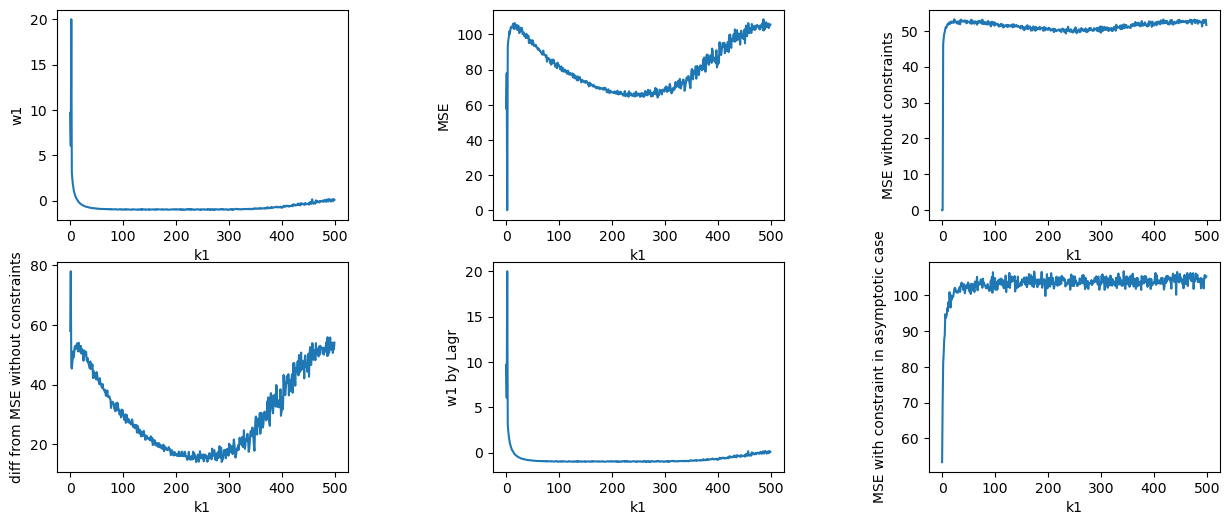

In [168]:
print('kVar =', 0.5)
K_3plots(500, 20,1, 0, 0.5)

# Comparison between behaviors of normal and uniform distribution

kVar = 0.5
this is normal!
[500, 18, 20, 20, 19, 19, 19, 20, 19, 19, 20, 19, 21, 20, 19, 19, 20, 20, 19, 20]
min w1: -2.6662910059145664
w list: [-2.66629101 -0.23445115  1.73214405  1.28085675  0.60676465  0.29890277
  6.03659748 -0.25239916 -0.05040401 -0.22163099  3.95156895 -0.2172399
  3.85738807  5.39009806 -0.24294165 -0.24072581  1.59956303 -0.24331952
 -0.2371821  -0.14729852]
sum of weights: 20.000000000000004
corresponding k1: 308
corresponding mse: 268.00884622616445


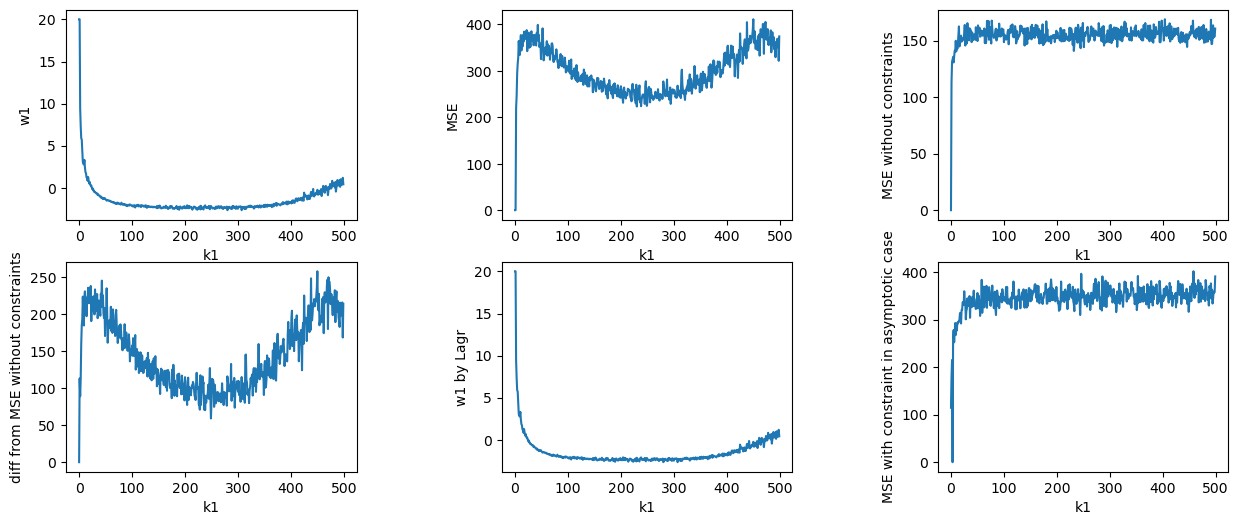

In [177]:
# Asymptotic case for normal
print('kVar =', 0.5)
K_3plots(500, 20, 0, 1, 0.5)

kVar = 0.5
this is uniform!
[500, 19, 20, 20, 19, 19, 18, 19, 20, 19, 20, 19, 19, 19, 20, 19, 19, 19, 19, 20]
min w1: -0.9130770885130609
w list: [-9.13077089e-01 -3.15529653e-02 -7.61440627e-02  1.31152100e-02
  3.31623115e-01 -1.44251014e-02  1.21061521e-01  1.62324469e+00
 -7.41749636e-02 -4.26198556e-02 -7.23288471e-02  8.46784321e-02
  2.91985682e-02  2.14050612e-01  4.22512759e+00 -6.81462920e-02
  1.46875229e+01 -6.31656490e-02  7.04132759e-02 -4.44011390e-02]
sum of weights: 20.000000000000004
corresponding k1: 235
corresponding mse: 335.193614074044


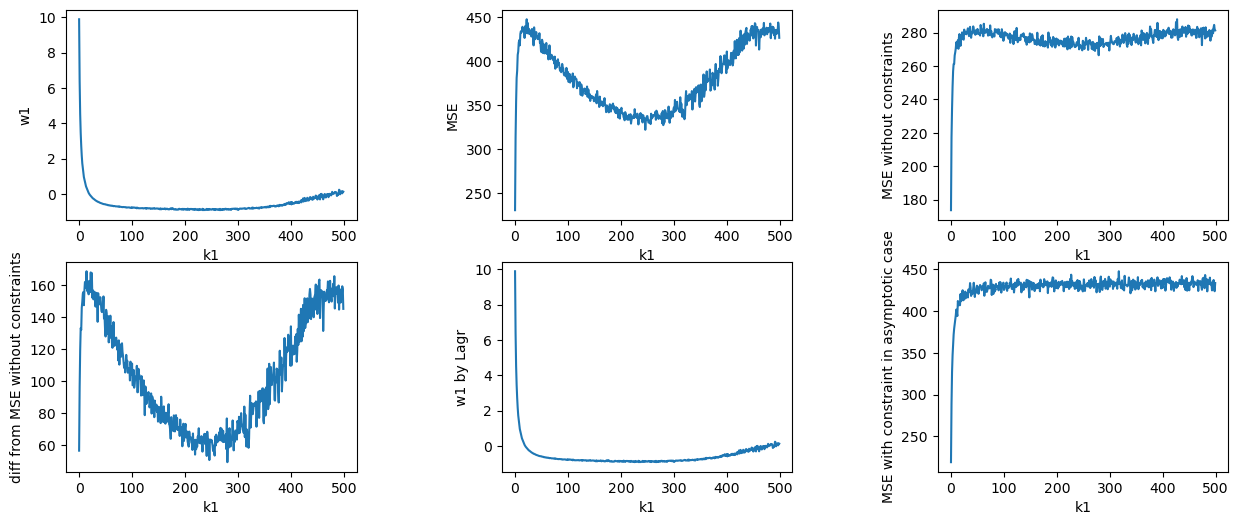

In [180]:
print('kVar =', 0.5)
K_3plots(500, 20,3, 0, 0.5)

kVar = 0.5
this is normal!
[500, 20, 20, 19, 20, 20, 19, 19, 19, 20, 19, 20, 19, 20, 20, 19, 20, 20, 20, 20]
min w1: -0.7176556907899514
w list: [-0.71765569 -0.11774609 -0.06626503  0.24933794 -0.04638078 -0.09475593
  0.65095453 -0.11071314  0.61872349  0.27695548 -0.11754877  0.49548711
 -0.09634237  0.17153226  2.43422499 13.60215498 -0.0898384  -0.11805256
  3.1919196  -0.11599163]
sum of weights: 20.000000000000007
corresponding k1: 195
corresponding mse: 1984.0259205428715


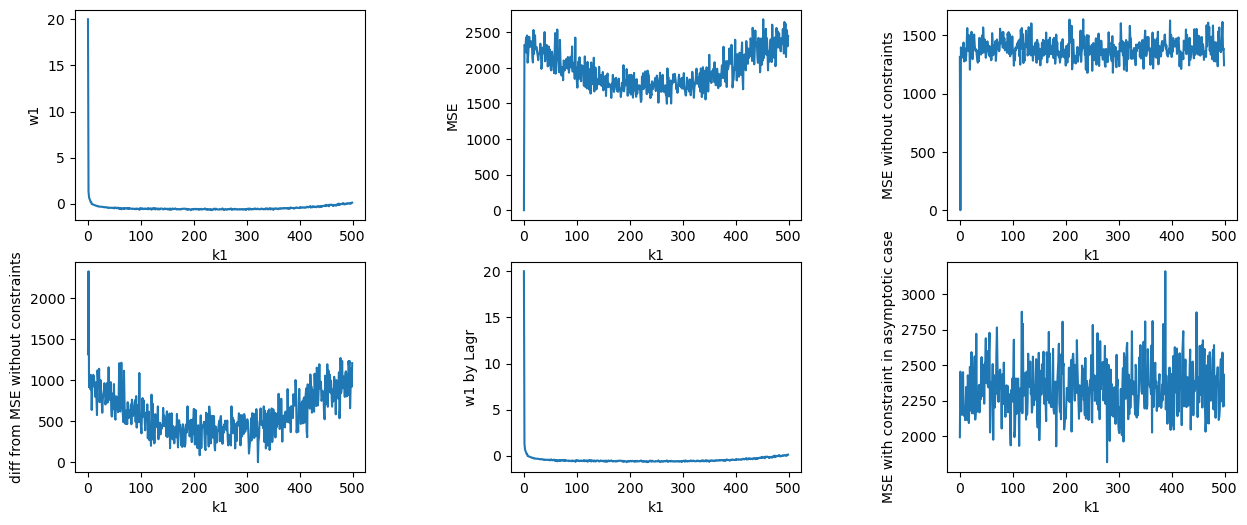

In [179]:
print('kVar =', 0.5)
K_3plots(500, 20, 0, 3, 0.5)